In [2]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import copy
import pylab
sns.set()

%matplotlib inline

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

### Generate data

In [4]:
# data generation function 
def generateData():
    n = 50
    d = 75
    #n = 4000
    #d = 6000
    k = 5 
    sigma = 1

    # generate x_i
    cov_mat = np.identity(d)
    avg = np.zeros((d,))
    x = np.random.multivariate_normal(avg,cov_mat,n)

    # epsilon vec
    epsilon_vec = np.random.normal(loc=0,scale=sigma)

    # w_star_0
    w_star_0 = 0
    w_star = np.zeros((d,))
    w_star[0:k] = np.random.randint(low = 1,high=3, size=k)
    w_star[w_star==2] = -10
    w_star[w_star==1] = 10


    # generate y 
    y = np.dot(x,w_star) + w_star_0 + epsilon_vec
    
    return y,x,w_star,k

# calculate what lambda max should be 
def lambda_max_func(x,y):
    k = np.shape(x)[1]
    n = np.shape(x)[0]
    sum_y = (1/n)*np.sum(y[:])
    y_reg = y - sum_y
    k_range = np.arange(k)
    lambda_max = np.max([2*np.abs(np.dot(x[:,k_ind].T,y_reg)) for k_ind in k_range])
    print('the max lambda is {}'.format(lambda_max))
    return lambda_max

    
### lasso function 
def lasso_CD(x,y,lambda_val,w_init):
    ### initialize conditions 
    delta = 1e-4
    n = np.shape(x)[0]
    d = np.shape(x)[1]

    stop_cond = 100
    w = np.array(w_init)
    a = np.zeros((d,))
    c = np.zeros((d,))
    stop_cond_vec = []
    w_old = np.zeros((d,))

    while(stop_cond>delta):
        diff_y_x = (y - np.dot(x,w))
        w_0 = (1/n)*np.sum(diff_y_x)
        for k in np.arange(d):
            a[k] = 2*np.dot(x[:,k].T,x[:,k])
            
            # subtract version
            
            diff_y_x_w0 = y - w_0 - np.dot(x,w) + x[:,k]*w[k]
            
            # bool version
#             mask = np.ones(d,dtype=bool)
#             mask[k] = 0
#             x_temp = x[:,mask]
#             w_temp = w[mask]

#             diff_y_x_w0 = y - w_0 - np.dot(x_temp,w_temp)
            c[k] = 2*np.dot(x[:,k].T,diff_y_x_w0)

            if c[k] < -lambda_val:
                w[k] = ((c[k]+lambda_val))/a[k]
            elif (np.abs(c[k]) < lambda_val):
                w[k] = 0
            elif c[k] > lambda_val:
                w[k] = ((c[k]-lambda_val))/a[k]

        weight_diff = w - w_old
        w_old = np.array(w)


        stop_cond = np.max(weight_diff)
        stop_cond_vec.append(stop_cond)
    
    return w,stop_cond_vec

# loop function which calls lasso 
def lasso_loop(x,y,k):
    w_vec = []
    num_non_zero_vec = []
    correct_non_zero_vec = []
    lambda_val = lambda_max_func(x,y)
    lambda_vec = []
    
    ground_truth = np.zeros((np.shape(x)[1],))
    ground_truth[0:5] = 1
    correct_elems = 100
    
    w_init = np.random.random(np.shape(x)[1])
    
    while (correct_elems>(33)):
        w,stop_cond_vec = lasso_CD(x,y,lambda_val,w_init)
        # total non zero 
        num_non_zero = sum((np.abs(x)>0 for x in w))
        
        # correct non zeros 
        w_logical = np.abs(w)>0
        correct_non_zero = sum(np.logical_and(ground_truth,w_logical))
        
        #w_init = np.array(w)
        w_init = np.random.random(np.shape(x)[1])

        w_vec.append(w)
        num_non_zero_vec.append(num_non_zero)
        correct_non_zero_vec.append(correct_non_zero)
        
        lambda_vec.append(lambda_val)
        
        ratio_val = 9/10
        
        lambda_val*=ratio_val
        correct_elems = sum(w_logical == ground_truth)
        print('lambda is {}'.format(lambda_val))

        print('number of correct elements is {}'.format(correct_elems))
    

    
    return w_vec,num_non_zero_vec,correct_non_zero_vec,lambda_vec

# plot precission and recall on the same graph 
def plot_precision_recall(num_non_zero_vec,correct_non_zero_vec,lambda_vec,k):
    
    
    # plot precision and recall 
    # count nonzero
    
    ax1 = plt.figure(figsize=(4, 4), dpi=600)
    ax1 = plt.figure()
    precision = np.array(correct_non_zero_vec)/np.array(num_non_zero_vec)
    #plt.semilogx(lambda_vec,precision,label='precision')
    plt.xlabel(r'$ \lambda $')
    recall = np.array(correct_non_zero_vec)/k
    plt.semilogx(lambda_vec,recall,label='recall')
    plt.ylabel('Normalized Precision/Recall')
    plt.title('Precision and Recall vs. Lambda for lasso')
    plt.legend()
    #plt.savefig('hw2_prob3_recall_precision_lasso_random')
    
# plot the lasso values as necessary 
def plot_lasso(w,stop_cond_vec,w_star):
    ax1 = sns.distplot(w, rug=True,hist=True,bins=100, kde=False, rug_kws={"color": "g"},hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})

    plt.figure()
    ax3 = plt.bar(np.arange(len(w_star)),w_star,label='w*')
    ax2 = plt.bar(np.arange(len(w)),1.1*w,label='computed weight matrix')
    plt.legend()
    plt.ylim([-10,10])

    plt.figure()
    ax3 = plt.plot(np.arange(len(stop_cond_vec)),stop_cond_vec)
    plt.ylim([0,0.05])

the max lambda is 1026.555041875301
lambda is 923.8995376877709
number of correct elements is 71
lambda is 831.5095839189938
number of correct elements is 73
lambda is 748.3586255270944
number of correct elements is 73
lambda is 673.522762974385
number of correct elements is 74
lambda is 606.1704866769466
number of correct elements is 74
lambda is 545.5534380092519
number of correct elements is 75
lambda is 490.9980942083267
number of correct elements is 75
lambda is 441.898284787494
number of correct elements is 75
lambda is 397.7084563087446
number of correct elements is 75
lambda is 357.9376106778701
number of correct elements is 75
lambda is 322.1438496100831
number of correct elements is 75
lambda is 289.9294646490748
number of correct elements is 75
lambda is 260.93651818416737
number of correct elements is 75
lambda is 234.84286636575064
number of correct elements is 75
lambda is 211.35857972917557
number of correct elements is 75
lambda is 190.222721756258
number of correct ele

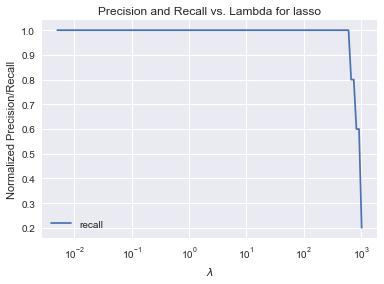

In [5]:
# generate data 
y,x,w_star,k = generateData()

# calculate the weight vector, number of non zeros, and lambda values 
w_vec,num_non_zero_vec,correct_non_zero_vec,lambda_vec = lasso_loop(x,y,k)

# plot the precission and recall 
plot_precision_recall(num_non_zero_vec,correct_non_zero_vec,lambda_vec,k)

In [6]:
lambda_vec_arr = np.array(lambda_vec)
mask = np.array(num_non_zero_vec)>5
masked = lambda_vec_arr[mask]
masked
num_non_zero_vec

[1,
 3,
 3,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 5,
 6,
 7,
 7,
 11,
 12,
 15,
 53]

# Below this is scratch work

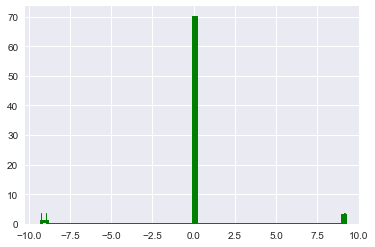

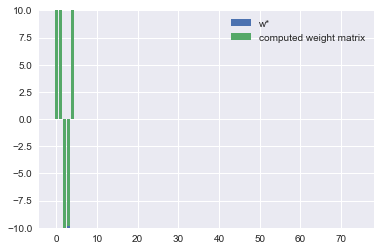

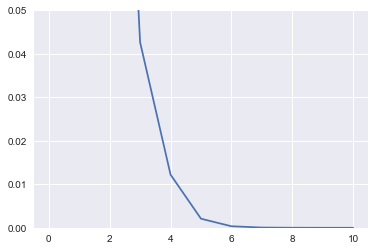

In [12]:
lambda_val = 100
w,stop_cond_vec = lasso_CD(x,y,lambda_val)
plot_lasso(w,stop_cond_vec,w_star)


In [34]:
np.sum([x==0 for x in w]

69

In [68]:
a = np.row_stack((w,w))

np.shape(a)

sum((x==0 for x in a.T))

(2, 75)

array([69, 69])

In [20]:
ground_truth = np.zeros((np.shape(x)[1],))
ground_truth[0:5] = 1

# total non zero 
num_non_zero = sum((x==0 for x in w))

# correct non zeros 
w_logical = w!=0

ground_truth 
correct_non_zero = sum(w_logical==ground_truth)
w_logical
print(w_logical)

array([ 1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [94]:
np.logical_and(ground_truth,w_logical)

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [50]:
print(np.abs(w_vec[167])>0)
print(np.abs(w_vec[167]))

[ True  True  True  True  True False False False  True False  True False
 False  True  True  True False False False False False  True False False
 False  True False False  True False False  True  True False  True False
 False False False  True False  True False False False False False False
 False False  True False False  True False  True False  True  True False
 False False  True  True False False False  True False False False False
 False False False]
[  1.00000000e+01   1.00000000e+01   1.00000000e+01   1.00000000e+01
   1.00000000e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.65034546e-16   0.00000000e+00   2.62064425e-16   0.00000000e+00
   0.00000000e+00   1.69814498e-17   4.04643914e-16   3.35177492e-16
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   6.50684662e-16   0.00000000e+00   0.00000000e+00
   0.00000000e+00   5.35443039e-16   0.00000000e+00   0.00000000e+00
   2.81110561e-16   0.00000000e+00   0.00000000e+00   1.523

In [23]:
mask = np.array(num_non_zero_vec)>5
mask
lambda_vec_array = np.array(lambda_vec)
lambda_vec_array


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

array([  1.28602928e+03,   1.02882342e+03,   8.23058739e+02,
         6.58446991e+02,   5.26757593e+02,   4.21406074e+02,
         3.37124860e+02,   2.69699888e+02,   2.15759910e+02,
         1.72607928e+02,   1.38086342e+02,   1.10469074e+02,
         8.83752592e+01,   7.07002073e+01,   5.65601659e+01,
         4.52481327e+01,   3.61985062e+01,   2.89588049e+01,
         2.31670439e+01,   1.85336352e+01,   1.48269081e+01,
         1.18615265e+01,   9.48922120e+00,   7.59137696e+00,
         6.07310157e+00,   4.85848125e+00,   3.88678500e+00,
         3.10942800e+00,   2.48754240e+00,   1.99003392e+00,
         1.59202714e+00,   1.27362171e+00,   1.01889737e+00,
         8.15117894e-01,   6.52094315e-01,   5.21675452e-01,
         4.17340362e-01,   3.33872290e-01,   2.67097832e-01,
         2.13678265e-01,   1.70942612e-01,   1.36754090e-01,
         1.09403272e-01,   8.75226175e-02,   7.00180940e-02,
         5.60144752e-02,   4.48115801e-02,   3.58492641e-02,
         2.86794113e-02,

In [6]:
a = np.array([1,2,3,4,5])
b = pylab.demean(a)
b

array([-2., -1.,  0.,  1.,  2.])